時刻同期のアルゴリズムの正しさの検証のため、角速度にフレーム番号を記録したデータを作成し、処理の正しさを検証する

生成するテストデータは、
推定値をファイルから読むgetAngularVeelocityFromJsonに入力Jsonするデータと、
ジャイロによる計測値を計測するsetMeasuredAngularVelocityに入力するJsonデータである

getAngularVelocityFromJsonについて
動画の横にあるC000X.jsonである。実在の動画の横に、偽のデータを作るのが良さそう。
とりあえず今問題になっているC0003.MP4とする。

JSONの生成は次のとおり。
データの並びはx,yのシフトと、回転量だと思われる。

データはcofidenceなら9105個並べれば良いらしい
データはあくまで画面上のシフト量なので、VG内部で角速度に変換されることに注意

In [162]:
#! /usr/bin/python3
import json
from collections import OrderedDict
import pprint
import os.path
import datetime
import cv2

def countVideoFrames(video_path):
    # 動画のフレーム数をカウント
    cap = cv2.VideoCapture(video_path)
    total_frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    return total_frame_count

def getVideoFPS(video_path):
    # 動画のフレーム数をカウント
    cap = cv2.VideoCapture(video_path)
    return cap.get(cv2.CAP_PROP_FPS)
    

def generateTestEstimatedData(length):
    output_dict = OrderedDict()
    output_dict["optical_flow"] = list()
    # for i in range(0,9104,1):

    for i in range(0,length,1):
        output_dict["optical_flow"].append(0.0)
        output_dict["optical_flow"].append(i*0.001)
        output_dict["optical_flow"].append(0.0)
        
    output_dict['confidence'] = list()
    for i in range(0,length,1):
        output_dict["confidence"].append(1)

    
    
    return output_dict

def videoToJson(video_path):
    return os.path.dirname(video_path) +'/'+ os.path.splitext(os.path.basename(video_path))[0]+ '.json'

def saveJson(filename, dict):
    with open( filename,'w') as f:
        json.dump(dict, f, indent=4)
    return filename


# test_data = generateTestData(91)
# print(json.dumps(test_data))
#     # filename = saveJson(test_data)

#     # print('Finished: '+ filename)
#     os.path.join()
    





setMeasuredAngularVelocityについて
普段はrecords以下に入っているyyyy-mm-dd_hh.mm.ss.json
中のデータは
- frequency
- angular_velocity_rad_per_sec
の順。


In [163]:

fy = 2937.489221417772
fps = 23.976023976023978
fps_gyro = 240.0

In [249]:
import math
def generateTestMeasuredData(length):
    output_dict = OrderedDict()
    output_dict["frequency"] = 240.0


    output_dict['angular_velocity_rad_per_sec'] = list()
    for i in range(0,length,1):
        output_dict["angular_velocity_rad_per_sec"].append(0.0)
        output_dict["angular_velocity_rad_per_sec"].append(0.0)
        output_dict["angular_velocity_rad_per_sec"].append(-fps * math.atan(i/fps_gyro*fps*0.001/fy))
    return output_dict

In [250]:
print(json.dumps(generateTestMeasuredData(91)))

{"frequency": 240.0, "angular_velocity_rad_per_sec": [0.0, 0.0, -0.0, 0.0, 0.0, -8.153926737664569e-07, 0.0, 0.0, -1.6307853475329119e-06, 0.0, 0.0, -2.4461780212993632e-06, 0.0, 0.0, -3.2615706950658085e-06, 0.0, 0.0, -4.0769633688322465e-06, 0.0, 0.0, -4.892356042598676e-06, 0.0, 0.0, -5.707748716365094e-06, 0.0, 0.0, -6.523141390131496e-06, 0.0, 0.0, -7.338534063897885e-06, 0.0, 0.0, -8.153926737664258e-06, 0.0, 0.0, -8.969319411430612e-06, 0.0, 0.0, -9.784712085196943e-06, 0.0, 0.0, -1.0600104758963255e-05, 0.0, 0.0, -1.1415497432729539e-05, 0.0, 0.0, -1.2230890106495798e-05, 0.0, 0.0, -1.3046282780262028e-05, 0.0, 0.0, -1.386167545402823e-05, 0.0, 0.0, -1.4677068127794398e-05, 0.0, 0.0, -1.5492460801560534e-05, 0.0, 0.0, -1.6307853475326628e-05, 0.0, 0.0, -1.712324614909269e-05, 0.0, 0.0, -1.7938638822858714e-05, 0.0, 0.0, -1.8754031496624692e-05, 0.0, 0.0, -1.9569424170390627e-05, 0.0, 0.0, -2.038481684415652e-05, 0.0, 0.0, -2.1200209517922367e-05, 0.0, 0.0, -2.201560219168816e-0

VirtualGimbalにテストデータを流し込んで結果を見てみる

まずはEstimated angular velocityのデータ

In [251]:
video_path = '/media/psf/Home/Dropbox/Mac/Documents/vgdataset/C0003.MP4'
video_frames = countVideoFrames(video_path)
print(getVideoFPS(video_path))
json_data = generateTestEstimatedData(video_frames)
saveJson(videoToJson(video_path),json_data)

23.976023976023978


'/media/psf/Home/Dropbox/Mac/Documents/vgdataset/C0003.json'

次にMeasured angular velocityのデータ

In [252]:
saveJson("../build/records/test.json",generateTestMeasuredData(int((video_frames/fps + 6)*fps_gyro)))

'../build/records/test.json'

In [253]:
import numpy as np
import json
import subprocess


In [254]:

from cProfile import label
import csv
import matplotlib.pyplot as plt

def openCSV(path):
    with open(path, 'r') as f:
        reader = csv.reader(f)
        header = next(reader)  # ヘッダー行を読み飛ばし

        data = []
        for row in reader:
            data.append(row)

    legends = [i for i in header]
    data = [[float(i) for i in row] for row in data]  # 文字列を数値に変換

    # X軸に時間を、Y軸にデータをセット
    eavf = [row[legends.index('Estimated angular velocity frame')] for row in data]
    mavf = [row[legends.index('Measured angular velocity frame')] for row in data]
    a = [row[legends.index('a-skew')] for row in data]
    b = [row[legends.index('b-offset')] for row in data]
    return eavf,mavf,a,b

In [255]:
def plotSync(x,y,labelx,labely,title):
    plt.figure(figsize=(10,6))
    plt.plot(x,y,'bo-')
    plt.xlabel(labelx)
    plt.ylabel(labely)          
    # plt.legend()
    plt.title(title)
    plt.grid()    
    plt.show()

In [256]:
def exec_vg_orig(path,record,offset=None):
    if offset is None:
        cmd = './pixelwise_stabilizer -i ' + path + ' -c ILCE-6500 -l SEL1670Z -j ' + record + ' -z 1.3 -n -a'
    else:
        cmd = './pixelwise_stabilizer -i ' + path + ' -c ILCE-6500 -l SEL1670Z -j ' + record + ' -z 1.3 -n -a -x frame_offset_' + format(offset,'1.4f') + '.json'
    
    res = None
    try:
        res = subprocess.check_call(cmd.split(),cwd="../build/")
    except:
        print("Error.")
    print(res)



In [257]:
test_data_path = '../build/records/test.json'

Error.
None


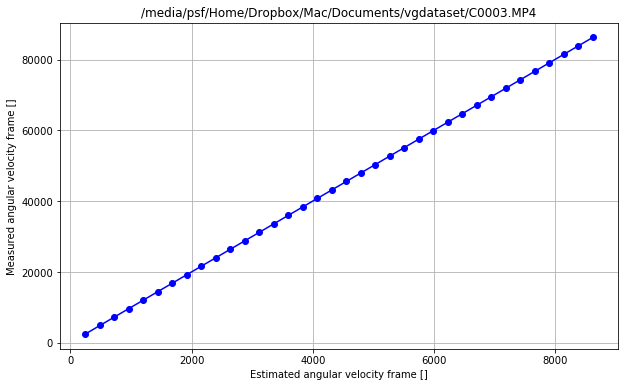

In [263]:
exec_vg_orig(video_path,test_data_path)

eavf,mavf,a,b = openCSV('../build/latest_sync_table.csv')
plotSync(eavf,mavf,'Estimated angular velocity frame []','Measured angular velocity frame []',"/media/psf/Home/Dropbox/Mac/Documents/vgdataset/C0003.MP4")

リサンプリングされたデータ

In [259]:
def plotLatestEstimatedAngularVelocity():
    with open('../build/latest_estimated_angular_velocity.csv', 'r') as f:
        reader = csv.reader(f)
        header = next(reader)  # ヘッダー行を読み飛ばし

        data = []
        for row in reader:
            data.append(row)

    legends = [i for i in header]
    data = [[float(i) for i in row] for row in data]  # 文字列を数値に変換

    # X軸に時間を、Y軸にデータをセット
    frame = [row[legends.index('Frame')] for row in data]
    rx = [row[legends.index('rx')] for row in data]
    ry = [row[legends.index('ry')] for row in data]
    rz = [row[legends.index('rz')] for row in data]

    plt.figure(figsize=(20,6))
    plt.plot(frame,rx,label='rx')
    plt.plot(frame,ry,label='ry')
    plt.plot(frame,rz,label='rz')
    plt.legend()
    return frame,rx,ry,rz

In [260]:
def plotLatestMeasuredAngularVelocityResampled():
    with open('../build/latest_measured_angular_velocity_resampled.csv', 'r') as f:
        reader = csv.reader(f)
        header = next(reader)  # ヘッダー行を読み飛ばし

        data = []
        for row in reader:
            data.append(row)

    legends = [i for i in header]
    data = [[float(i) for i in row] for row in data]  # 文字列を数値に変換

    # X軸に時間を、Y軸にデータをセット
    frame = [row[legends.index('Frame')] for row in data]
    rx = [row[legends.index('x')] for row in data]
    ry = [row[legends.index('y')] for row in data]
    rz = [row[legends.index('z')] for row in data]

    plt.figure(figsize=(20,6))
    plt.plot(frame,rx,label='x')
    plt.plot(frame,ry,label='y')
    plt.plot(frame,rz,label='z')
    plt.legend()
    return frame,rx,ry,rz

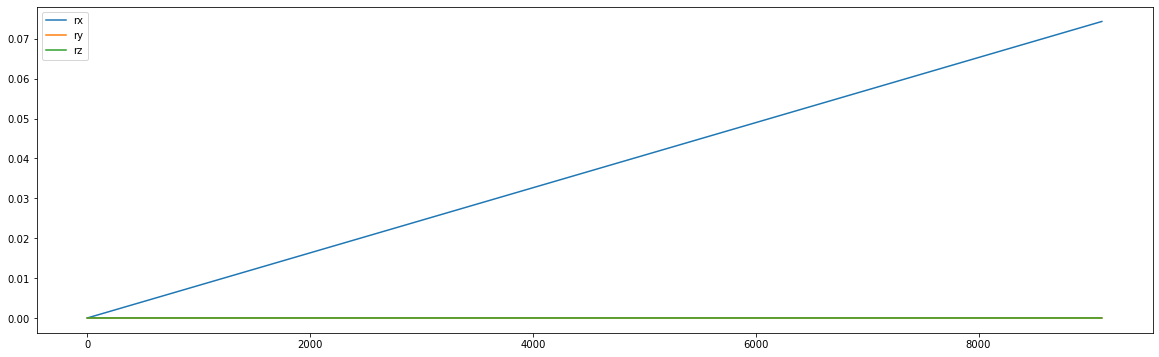

In [261]:
frame,rx,ry,rz = plotLatestEstimatedAngularVelocity()


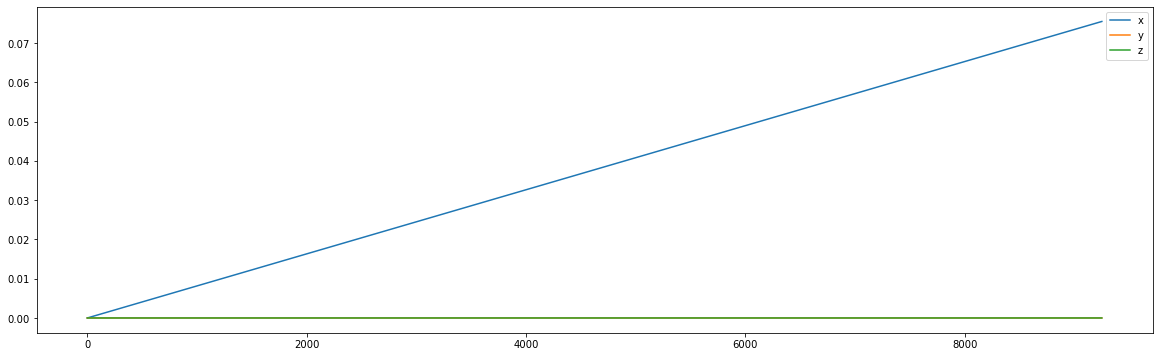

In [262]:
frame,rx,ry,rz = plotLatestMeasuredAngularVelocityResampled()

In [247]:
rx[1000]

-0.008162

In [248]:
1./rx[1000]

-122.51899044351873